# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from itertools import product
from time import perf_counter, time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.router_env import RouterEnv
from custom_env.actions import Acciones

from gymnasium import make
from gymnasium.utils import seeding
from gymnasium.utils.env_checker import check_env
from matplotlib.ticker import MaxNLocator
from pandas import DataFrame, Series
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

In [2]:
name = "Example"
progress_bar = True
if progress_bar:
    import rich
    import tqdm

## Clases y Funciones


In [3]:

"""

class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")
    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


gen = DOS_Packet_Generator(step_dur=1e-6,seed=1)




print(len(gen.generate_packets()))

"""

'\n\nclass PacketAttack(Enum):\n    @staticmethod\n    def new_set(description, weight, class_ref):\n        return {\n            "Description": description,\n            "weight": weight,\n            "class": class_ref\n        }\n\n    @staticmethod\n    def not_implemented():\n        raise NotImplementedError(f"Class not implemented")\n    @classmethod\n    @cache\n    def weights(cls):\n        attack_weights = []\n        for attack in PacketAttack:\n            attack_weights.append(attack.value["weight"])\n        return np.array(attack_weights)\n\n    # ----ENUM VALUES----\n    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)\n    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)\n\n\ngen = DOS_Packet_Generator(step_dur=1e-6,seed=1)\n\n\n\n\nprint(len(gen.generate_packets()))\n\n'

In [4]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun

## Entrenamiento


In [5]:
tmp_path = "./train_log/"
env_id = "RouterEnv-v0"

seed = None
env = make(env_id, seed=seed)
# env = RouterEnv(seed=None)
check_env(env)

new_logger: Logger = configure(tmp_path, ["stdout", "csv"])
env = Monitor(env, tmp_path)


model: PPO = PPO("MlpPolicy", env,
                 verbose=True)


"""
eval_callback = EvalCallback(
    env,  # Entorno de evaluación
    best_model_save_path="./logs/best_model",  # Ruta para guardar el mejor modelo
    log_path="./logs",  # Ruta para guardar estadísticas
    eval_freq=10000,  # Frecuencia de evaluación (en pasos)
    deterministic=True,
    render=False,
)
, callback=eval_callback
"""
"""
ep_info = a.ep_info_buffer
print(a.ep_info_buffer)
if ep_info is not None and len(ep_info) > 0:
    rew=ep_info[0]["r"]
    print(rew)
    saved= PPO.load("Example")
    print(ep_info.pop())
"""


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Logging to ./train_log/


Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 164      |
| time/              |          |
|    fps             | 616      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 190         |
| time/                   |             |
|    fps                  | 556         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020513818 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.678      |
|    explained_variance   | 0.000483    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.1         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.044      |
|    value_loss           | 21.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 43.4        |
| time/                   |             |
|    fps                  | 506         |
|    iterations           | 3           |
|    time_elapsed         | 12          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.023995668 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.632      |
|    explained_variance   | -0.00958    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.27        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 17.1        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 16.9         |
| time/                   |              |
|    fps                  | 506          |
|    iterations           | 4            |
|    time_elapsed         | 16           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0006788003 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.616       |
|    explained_variance   | 0.075        |
|    learning_rate        | 0.0003       |
|    loss                 | 209          |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 604          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 63.5         |
| time/                   |              |
|    fps                  | 507          |
|    iterations           | 5            |
|    time_elapsed         | 20           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0024849628 |
|    clip_fraction        | 0.00342      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.563        |
|    learning_rate        | 0.0003       |
|    loss                 | 275          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0034      |
|    value_loss           | 602          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 99.3        |
| time/                   |             |
|    fps                  | 511         |
|    iterations           | 6           |
|    time_elapsed         | 24          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.003969825 |
|    clip_fraction        | 0.00776     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.605      |
|    explained_variance   | -0.0198     |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00325    |
|    value_loss           | 26.2        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 122          |
| time/                   |              |
|    fps                  | 514          |
|    iterations           | 7            |
|    time_elapsed         | 27           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0062436583 |
|    clip_fraction        | 0.0736       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.548       |
|    explained_variance   | 0.106        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.7         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00588     |
|    value_loss           | 31.9         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 139         |
| time/                   |             |
|    fps                  | 515         |
|    iterations           | 8           |
|    time_elapsed         | 31          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.007887143 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.602      |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.2        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00616    |
|    value_loss           | 122         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 157          |
| time/                   |              |
|    fps                  | 514          |
|    iterations           | 9            |
|    time_elapsed         | 35           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0022707426 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.582       |
|    explained_variance   | 0.773        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.8         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.000704    |
|    value_loss           | 39.3         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 171         |
| time/                   |             |
|    fps                  | 515         |
|    iterations           | 10          |
|    time_elapsed         | 39          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.011152951 |
|    clip_fraction        | 0.0767      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.7        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00408    |
|    value_loss           | 45.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 513         |
|    iterations           | 11          |
|    time_elapsed         | 43          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.008050218 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.44       |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.5        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00247    |
|    value_loss           | 48.9        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 194          |
| time/                   |              |
|    fps                  | 515          |
|    iterations           | 12           |
|    time_elapsed         | 47           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0127601605 |
|    clip_fraction        | 0.0753       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.489       |
|    explained_variance   | 0.49         |
|    learning_rate        | 0.0003       |
|    loss                 | 67.9         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00696     |
|    value_loss           | 95.3         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 212          |
| time/                   |              |
|    fps                  | 515          |
|    iterations           | 13           |
|    time_elapsed         | 51           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0045319716 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.425       |
|    explained_variance   | 0.549        |
|    learning_rate        | 0.0003       |
|    loss                 | 17.7         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0031      |
|    value_loss           | 52           |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 219         |
| time/                   |             |
|    fps                  | 517         |
|    iterations           | 14          |
|    time_elapsed         | 55          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.017042551 |
|    clip_fraction        | 0.0978      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.448      |
|    explained_variance   | -0.663      |
|    learning_rate        | 0.0003      |
|    loss                 | 60.8        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0063     |
|    value_loss           | 224         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 226         |
| time/                   |             |
|    fps                  | 517         |
|    iterations           | 15          |
|    time_elapsed         | 59          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.004935459 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.394      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 39          |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 70.1        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 229          |
| time/                   |              |
|    fps                  | 517          |
|    iterations           | 16           |
|    time_elapsed         | 63           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0027496633 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.444       |
|    explained_variance   | 0.417        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.2         |
|    n_updates            | 150          |
|    policy_gradient_loss | -4.74e-05    |
|    value_loss           | 60.9         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 230         |
| time/                   |             |
|    fps                  | 519         |
|    iterations           | 17          |
|    time_elapsed         | 67          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.006843542 |
|    clip_fraction        | 0.0504      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.457      |
|    explained_variance   | 0.539       |
|    learning_rate        | 0.0003      |
|    loss                 | 30.7        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00209    |
|    value_loss           | 71.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 237         |
| time/                   |             |
|    fps                  | 520         |
|    iterations           | 18          |
|    time_elapsed         | 70          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.009231079 |
|    clip_fraction        | 0.0771      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.465      |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.3        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00185    |
|    value_loss           | 76.5        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 246          |
| time/                   |              |
|    fps                  | 522          |
|    iterations           | 19           |
|    time_elapsed         | 74           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0003503376 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 0.113        |
|    learning_rate        | 0.0003       |
|    loss                 | 40           |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.000503    |
|    value_loss           | 80.7         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 252          |
| time/                   |              |
|    fps                  | 523          |
|    iterations           | 20           |
|    time_elapsed         | 78           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0026487354 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.362       |
|    explained_variance   | -0.557       |
|    learning_rate        | 0.0003       |
|    loss                 | 44.6         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00171     |
|    value_loss           | 159          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 259          |
| time/                   |              |
|    fps                  | 523          |
|    iterations           | 21           |
|    time_elapsed         | 82           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0034950809 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.323       |
|    explained_variance   | 0.177        |
|    learning_rate        | 0.0003       |
|    loss                 | 58.1         |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 76.2         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 268          |
| time/                   |              |
|    fps                  | 522          |
|    iterations           | 22           |
|    time_elapsed         | 86           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0039070416 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.401       |
|    explained_variance   | 0.144        |
|    learning_rate        | 0.0003       |
|    loss                 | 85.7         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 106          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 301         |
| time/                   |             |
|    fps                  | 523         |
|    iterations           | 23          |
|    time_elapsed         | 89          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.010789945 |
|    clip_fraction        | 0.0967      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.516      |
|    explained_variance   | -0.0791     |
|    learning_rate        | 0.0003      |
|    loss                 | 157         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 312         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 320          |
| time/                   |              |
|    fps                  | 524          |
|    iterations           | 24           |
|    time_elapsed         | 93           |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0021898856 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.0505       |
|    learning_rate        | 0.0003       |
|    loss                 | 23.9         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.000235    |
|    value_loss           | 118          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 325         |
| time/                   |             |
|    fps                  | 524         |
|    iterations           | 25          |
|    time_elapsed         | 97          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.009929335 |
|    clip_fraction        | 0.0903      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.159       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.4        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 94.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 327         |
| time/                   |             |
|    fps                  | 524         |
|    iterations           | 26          |
|    time_elapsed         | 101         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.004222976 |
|    clip_fraction        | 0.0607      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.0945      |
|    learning_rate        | 0.0003      |
|    loss                 | 44.9        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0045     |
|    value_loss           | 131         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 335          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 27           |
|    time_elapsed         | 105          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0011601627 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.343       |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 31.5         |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 84.7         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 343         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 28          |
|    time_elapsed         | 109         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.004720052 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.339      |
|    explained_variance   | 0.0613      |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 183         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 344          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 29           |
|    time_elapsed         | 112          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0070352345 |
|    clip_fraction        | 0.0848       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.321       |
|    explained_variance   | 0.0253       |
|    learning_rate        | 0.0003       |
|    loss                 | 180          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00498     |
|    value_loss           | 221          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 347          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 30           |
|    time_elapsed         | 116          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0027386516 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.375       |
|    explained_variance   | 0.114        |
|    learning_rate        | 0.0003       |
|    loss                 | 91.8         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00192     |
|    value_loss           | 118          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 346          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 31           |
|    time_elapsed         | 120          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0030145803 |
|    clip_fraction        | 0.0283       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.257       |
|    explained_variance   | 0.0902       |
|    learning_rate        | 0.0003       |
|    loss                 | 7.15         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.000727    |
|    value_loss           | 102          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 348          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 32           |
|    time_elapsed         | 124          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0024099934 |
|    clip_fraction        | 0.0126       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.327       |
|    explained_variance   | 0.126        |
|    learning_rate        | 0.0003       |
|    loss                 | 93.3         |
|    n_updates            | 310          |
|    policy_gradient_loss | 3.39e-05     |
|    value_loss           | 117          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 345          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 33           |
|    time_elapsed         | 128          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0035696025 |
|    clip_fraction        | 0.0563       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.267       |
|    explained_variance   | 0.13         |
|    learning_rate        | 0.0003       |
|    loss                 | 31.8         |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.00309     |
|    value_loss           | 122          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 350           |
| time/                   |               |
|    fps                  | 527           |
|    iterations           | 34            |
|    time_elapsed         | 132           |
|    total_timesteps      | 69632         |
| train/                  |               |
|    approx_kl            | 0.00016116751 |
|    clip_fraction        | 0.00801       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.218        |
|    explained_variance   | 0.0484        |
|    learning_rate        | 0.0003        |
|    loss                 | 52.1          |
|    n_updates            | 330           |
|    policy_gradient_loss | 0.000313      |
|    value_loss           | 110           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 352          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 35           |
|    time_elapsed         | 136          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0009877761 |
|    clip_fraction        | 0.00527      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.332       |
|    explained_variance   | -0.0173      |
|    learning_rate        | 0.0003       |
|    loss                 | 118          |
|    n_updates            | 340          |
|    policy_gradient_loss | 0.000755     |
|    value_loss           | 208          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 359         |
| time/                   |             |
|    fps                  | 527         |
|    iterations           | 36          |
|    time_elapsed         | 139         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.004782575 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.364      |
|    explained_variance   | -0.00311    |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00185    |
|    value_loss           | 132         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 361          |
| time/                   |              |
|    fps                  | 528          |
|    iterations           | 37           |
|    time_elapsed         | 143          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0012348107 |
|    clip_fraction        | 0.0126       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.0549       |
|    learning_rate        | 0.0003       |
|    loss                 | 68.5         |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00129     |
|    value_loss           | 104          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 356          |
| time/                   |              |
|    fps                  | 528          |
|    iterations           | 38           |
|    time_elapsed         | 147          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0012717082 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.125        |
|    learning_rate        | 0.0003       |
|    loss                 | 79.5         |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00414     |
|    value_loss           | 117          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 356          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 39           |
|    time_elapsed         | 151          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0011840102 |
|    clip_fraction        | 0.0572       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.282       |
|    explained_variance   | 0.243        |
|    learning_rate        | 0.0003       |
|    loss                 | 72.3         |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 106          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 373          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 40           |
|    time_elapsed         | 155          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0035214527 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.284       |
|    explained_variance   | 0.227        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.6         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 97.6         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 370         |
| time/                   |             |
|    fps                  | 527         |
|    iterations           | 41          |
|    time_elapsed         | 159         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.016935915 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.317      |
|    explained_variance   | -0.113      |
|    learning_rate        | 0.0003      |
|    loss                 | 362         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0082     |
|    value_loss           | 609         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 368          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 42           |
|    time_elapsed         | 163          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0011498972 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | 45.3         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00015     |
|    value_loss           | 120          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 378          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 43           |
|    time_elapsed         | 167          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0024726472 |
|    clip_fraction        | 0.0349       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.109        |
|    learning_rate        | 0.0003       |
|    loss                 | 56.2         |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.000716    |
|    value_loss           | 140          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 378         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 44          |
|    time_elapsed         | 171         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.006321051 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.289      |
|    explained_variance   | -0.107      |
|    learning_rate        | 0.0003      |
|    loss                 | 147         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00351    |
|    value_loss           | 332         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 379         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 45          |
|    time_elapsed         | 174         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.002890817 |
|    clip_fraction        | 0.0256      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.0423      |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00163    |
|    value_loss           | 153         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 390          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 46           |
|    time_elapsed         | 179          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0024486328 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.278       |
|    explained_variance   | 0.035        |
|    learning_rate        | 0.0003       |
|    loss                 | 118          |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000688    |
|    value_loss           | 234          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 389          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 47           |
|    time_elapsed         | 183          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0033916275 |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | -0.00596     |
|    learning_rate        | 0.0003       |
|    loss                 | 177          |
|    n_updates            | 460          |
|    policy_gradient_loss | 0.000404     |
|    value_loss           | 527          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 385          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 48           |
|    time_elapsed         | 187          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0033089586 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.0642       |
|    learning_rate        | 0.0003       |
|    loss                 | 62.6         |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000477    |
|    value_loss           | 126          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 387         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 49          |
|    time_elapsed         | 190         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.005288381 |
|    clip_fraction        | 0.0325      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.0003      |
|    loss                 | 119         |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.000634   |
|    value_loss           | 128         |
-----------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


['time/fps', 'time/total_timesteps', 'rollout/ep_rew_mean', 'time/time_elapsed', 'time/iterations', 'rollout/ep_len_mean', 'train/entropy_loss', 'train/n_updates', 'train/policy_gradient_loss', 'train/clip_fraction', 'train/value_loss', 'train/explained_variance', 'train/learning_rate', 'train/clip_range', 'train/approx_kl', 'train/loss']


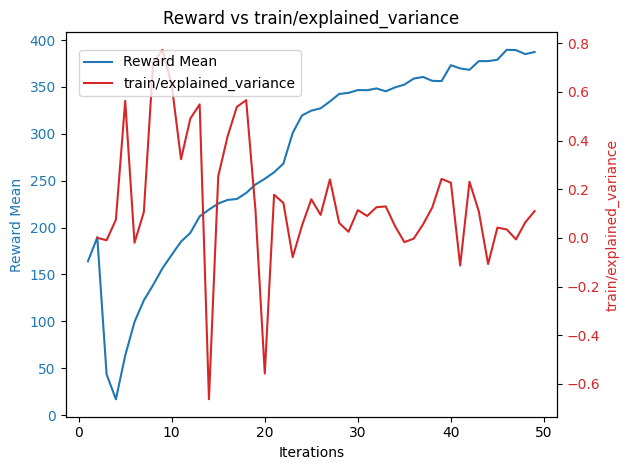

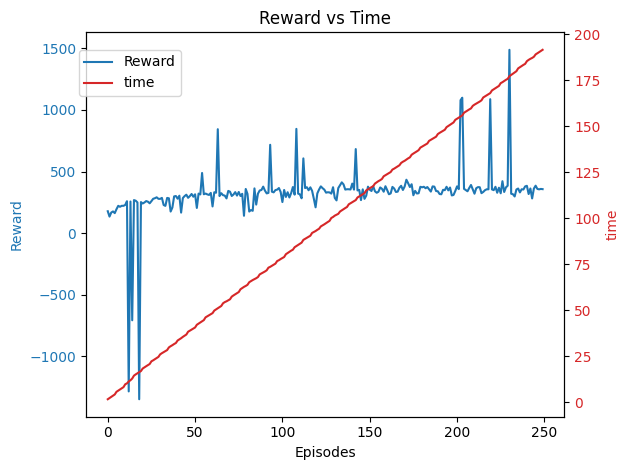

In [6]:
train_data_log: DataFrame = pd.read_csv(tmp_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv", header=1)

# train_data_monitor = pd.concat([train_data_monitor] * 3, ignore_index=True)
print(train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [7]:
seed = None
env = RouterEnv(seed=seed)
model = PPO.load(name, print_system_info=True)

num_steps = 1
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards = []
ocu = []
tams = []
num = []
lim_ocu = 0
a2 = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        if len(ant) > 0 and ant != info:
            print(info["Stats"])
        ant = info

        ocu.append(info["Stats"]["OcupacionActual"])
        lim_ocu = info["Stats"]["LimiteOcupación"]
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])

        rewards.append(reward)
        acciones.append(action.item())

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x, 0)), rewards)))
print(a2)

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.0, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 4, 'TamañoTotal': 423.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.016, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 8, 'TamañoTotal': 744.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.032, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 11, 'TamañoTotal': 1028.0, 'Action': <Acciones.PERMIT

In [8]:
assert len(acciones) != a2.count(Acciones.DENEGAR)
assert len(acciones) != a2.count(Acciones.PERMITIR)

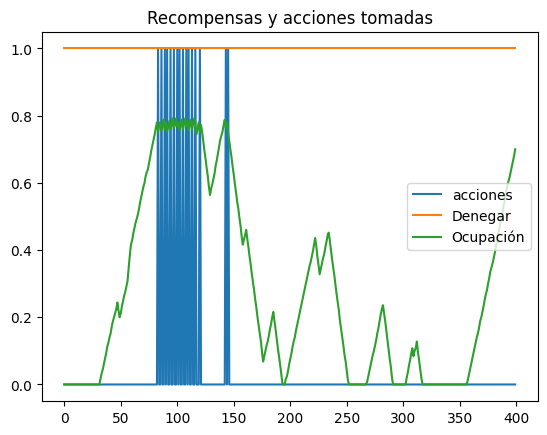

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [9]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]
         * len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print("Rewards: ", rewards)
num_permitidos = acciones.count(Acciones.action_to_int(Acciones.PERMITIR))
print(num_permitidos, len(acciones)-num_permitidos, "",
      num_permitidos/len(acciones), 1-num_permitidos/len(acciones))

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.044, 0.06, 0.076, 0.092, 0.112, 0.124, 0.14, 0.152, 0.172, 0.188, 0.2, 0.212, 0.224, 0.244, 0.22, 0.2, 0.212, 0.232, 0.248, 0.264, 0.276, 0.292, 0.308, 0.348, 0.384, 0.416, 0.428, 0.448, 0.464, 0.48, 0.492, 0.504, 0.52, 0.54, 0.556, 0.572, 0.588, 0.6, 0.62, 0.632, 0.64, 0.66, 0.676, 0.696, 0.712, 0.728, 0.744, 0.764, 0.78, 0.752, 0.768, 0.78, 0.756, 0.768, 0.788, 0.76, 0.78, 0.752, 0.768, 0.784, 0.76, 0.772, 0.792, 0.764, 0.772, 0.792, 0.768, 0.78, 0.756, 0.772, 0.788, 0.76, 0.776, 0.792, 0.768, 0.784, 0.756, 0.772, 0.788, 0.76, 0.776, 0.792, 0.764, 0.744, 0.764, 0.78, 0.752, 0.772, 0.752, 0.724, 0.696, 0.672, 0.644, 0.62, 0.588, 0.564, 0.584, 0.596, 0.612, 0.628, 0.652, 0.668, 0.688, 0.708, 0.728, 0.74, 0.752, 0.772, 0.788, 0.764, 0.78, 0.748, 0.724, 0.7, 0.676, 0.648, 0.624, 0.596, 0.572, 0.544, 0.

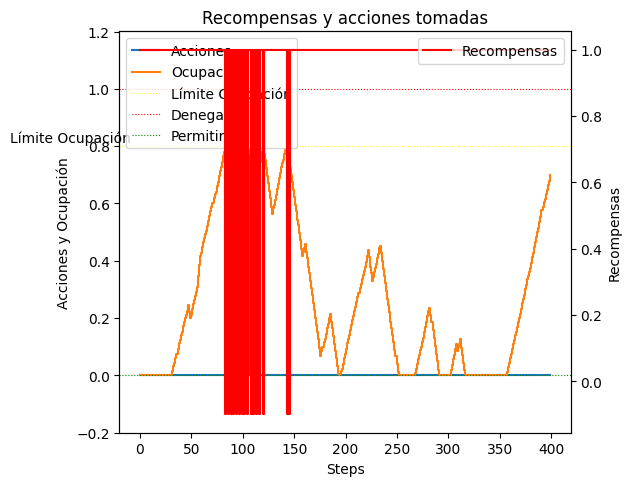

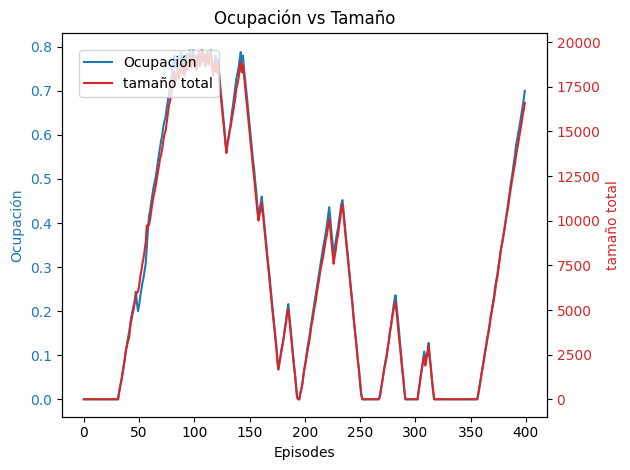

La ocupación máxima es de 79%
La ocupación mínima es de 0%


In [10]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post')
# ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted',
            linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación',
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5),
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x/1 for x in tams]


"""
plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")
"""

fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tams)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

"""plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')


plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()"""
print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")

## Pruebas:


In [11]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones) > 1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


In [12]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'Estado

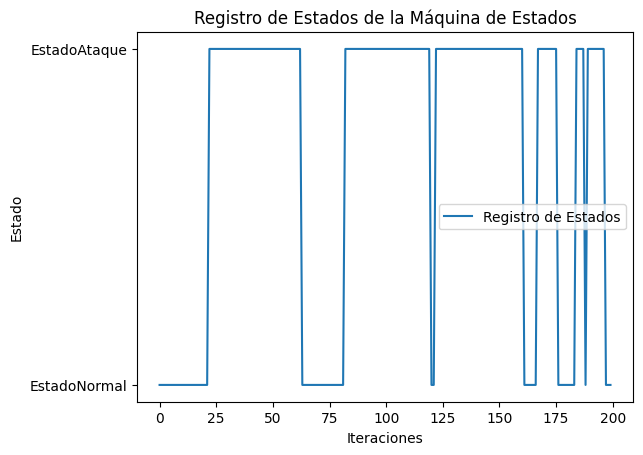

In [13]:
from custom_env.states import *
maquina = MaquinaDeEstados()
for _ in range(200):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [14]:
# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {
    x: 0 for x in combinaciones_con_repeticion}

print(dict_con)
duracion_ataques = []
estado_Ant = maquina.registro_estados[0]

for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Ant, estado)] += 1

    if (estado_Ant, estado) == (EstadoNormal.__name__, EstadoAtaque.__name__):  # Empieza ataque
        duracion_ataques.append(1)
    elif (estado_Ant, estado) == (EstadoAtaque.__name__, EstadoAtaque.__name__):  # Sigue ataque
        if len(duracion_ataques) > 0:
            duracion_ataques[-1] += 1

    estado_Ant: Estado = estado

print(
    f"Como promedio los {len(duracion_ataques)} ataques duran {np.mean(duracion_ataques):.1f} iteraciones.")
print("Duracion 5 primeros ataques: ", duracion_ataques[:5], "...")
try:
    for estado1 in lista:
        total = 0
        for estado2 in lista:
            total += dict_con[(estado1, estado2)]
        print(f"Estando en {estado1}:")
        for estado2 in lista:
            print(f"De {estado1} a {estado2}: {
                dict_con[(estado1, estado2)] / total:6.2%}")
except:
    pass

{('EstadoNormal', 'EstadoNormal'): 0, ('EstadoNormal', 'EstadoAtaque'): 0, ('EstadoAtaque', 'EstadoNormal'): 0, ('EstadoAtaque', 'EstadoAtaque'): 0}
Como promedio los 6 ataques duran 23.2 iteraciones.
Duracion 5 primeros ataques:  [41, 38, 39, 9, 4] ...
Estando en EstadoNormal:
De EstadoNormal a EstadoNormal: 90.00%
De EstadoNormal a EstadoAtaque: 10.00%
Estando en EstadoAtaque:
De EstadoAtaque a EstadoNormal:  4.32%
De EstadoAtaque a EstadoAtaque: 95.68%


In [15]:
_np_random, _ = seeding.np_random(None)
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=True))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=False))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
print(type(0.0), type(0))
print(int(0.2))

1,10,6,3
1,9,5,3
<class 'float'> <class 'int'>
0
